The idea now:
Since their implementation of the model requires packages only available for a linux engine, I will have to retrofit their model to work on my computer.

For the SingleStream network I need:
- Visual Encoder:
    - S3D Backbone 1-4 blocks, outputs S3D features (T/4x843) --> these features are used for the head network                    CHECK
    - Head network, outputs Gloss representations in high dim space (T/4x512) --> These are the features sent forward to the S2T  CHECK
        - Linear/BN/ReLU                                                                                                          CHECK
        - Temporal Cov Block                                                                                                      CHECK
    - Linear classifier, outputs Gloss logits (T/4xK)                                                                             CHECK
    - Softmax, outputs gloss probabilities (T/4xK)                                                                                CHECK
    - and then the CTC (connectionist temporal classification) loss and the CTC Decoder (which outputs Gloss Predictions)

- Pretraining of the Visual Encoder (not necessary since we will be using their pretrained weights).

- V-L Mapper

### UTILS

In [1]:
import copy
import glob
import os
import os.path
import errno
import shutil
import random
import logging
from sys import platform
from logging import Logger
from typing import Callable, Optional
import numpy as np
import cv2
import pandas as pd
from torchinfo import summary
import pickle
import gzip

import torch
from torch import nn, Tensor
import yaml
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

def neq_load_customized(model, pretrained_dict, verbose=False):
    ''' load pre-trained model in a not-equal way,
    when new model has been partially modified '''
    model_dict = model.state_dict()
    tmp = {}
    if verbose:
        print(list(model_dict.keys()))
        print('\n=======Check Weights Loading======')
        print('Weights not used from pretrained file:')
    for k, v in pretrained_dict.items():
        if k in model_dict and model_dict[k].shape==v.shape:
            tmp[k] = v
        else:
            if verbose:
                print(k)
    if verbose:
        print('---------------------------')
        print('Weights not loaded into new model:')
        for k, v in model_dict.items():
            if k not in pretrained_dict:
                print(k)
            elif model_dict[k].shape != pretrained_dict[k].shape:
                print(k, 'shape mis-matched, not loaded')
        print('===================================\n')

    del pretrained_dict
    model_dict.update(tmp)
    del tmp
    model.load_state_dict(model_dict)
    return model


def get_logger():
    return Logger

## S3D

#### S3D Architecture

In [2]:
### S3D Model architecture

class S3Dsup(nn.Module):
    def __init__(self, in_channels, num_class, use_block, stride):
        super(S3Dsup, self).__init__()
        base_seq = []
        if use_block>=1:
            base_seq += [
                SepConv3d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            ]
        if use_block>=2:
            base_seq += [
                nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(
                    1, 2, 2), padding=(0, 1, 1)),                        # 1
                BasicConv3d(64, 64, kernel_size=1, stride=1),            # 2
                SepConv3d(64, 192, kernel_size=3, stride=1, padding=1),  # 3
            ]
        if use_block>=3:
            base_seq += [
                nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(
                    1, 2, 2), padding=(0, 1, 1)),                        # 4
                Mixed_3b(),                                              # 5
                Mixed_3c(),                                              # 6
            ]
        if use_block>=4:
            base_seq += [
                nn.MaxPool3d(kernel_size=(3, 3, 3), stride=(
                    2, 2, 2), padding=(1, 1, 1)),                        # 7
                Mixed_4b(),                                              # 8
                Mixed_4c(),                                              # 9
                Mixed_4d(),                                              # 10
                Mixed_4e(),                                              # 11
                Mixed_4f(),                                              # 12
            ]
        if use_block>=5:
            base_seq += [
                nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(
                    stride, 2, 2), padding=(0 if stride==2 else 1, 0, 0)),
                Mixed_5b(),
                Mixed_5c(), #15
            ]
        self.base_num_layers = len(base_seq)
        self.base = nn.Sequential(*base_seq)
        #self.fc = nn.Sequential(nn.Conv3d(BLOCK2SIZE[use_block], num_class, kernel_size=1, stride=1, bias=True)) 
        # Took the standard fc from S3D class pytorch, allows the model to load the weights, so we assume it's the right one
        # 1024 for kinetics, 832 for gloss since different blocksize

    def forward(self, x):
        y = self.base(x)
        y = F.avg_pool3d(y, (2, y.size(3), y.size(4)), stride=1)
        #y = self.fc(y)
        y = y.view(y.size(0), y.size(1), y.size(2))
        logits = torch.mean(y, 2)

        return logits


class BasicConv3d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv3d, self).__init__()
        self.conv = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm3d(out_planes, eps=1e-3, momentum=0.001, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class SepConv3d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(SepConv3d, self).__init__()
        self.conv_s = nn.Conv3d(in_planes, out_planes, kernel_size=(1,kernel_size,kernel_size), stride=(1,stride,stride), padding=(0,padding,padding), bias=False)
        self.bn_s = nn.BatchNorm3d(out_planes, eps=1e-3, momentum=0.001, affine=True)
        self.relu_s = nn.ReLU()

        self.conv_t = nn.Conv3d(out_planes, out_planes, kernel_size=(kernel_size,1,1), stride=(stride,1,1), padding=(padding,0,0), bias=False)
        self.bn_t = nn.BatchNorm3d(out_planes, eps=1e-3, momentum=0.001, affine=True)
        self.relu_t = nn.ReLU()

    def forward(self, x):
        x = self.conv_s(x)
        x = self.bn_s(x)
        x = self.relu_s(x)

        x = self.conv_t(x)
        x = self.bn_t(x)
        x = self.relu_t(x)
        return x

class Mixed_3b(nn.Module):
    def __init__(self):
        super(Mixed_3b, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(192, 64, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(192, 96, kernel_size=1, stride=1),
            SepConv3d(96, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(192, 16, kernel_size=1, stride=1),
            SepConv3d(16, 32, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(192, 32, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)

        return out


class Mixed_3c(nn.Module):
    def __init__(self):
        super(Mixed_3c, self).__init__()
        self.branch0 = nn.Sequential(
            BasicConv3d(256, 128, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(256, 128, kernel_size=1, stride=1),
            SepConv3d(128, 192, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(256, 32, kernel_size=1, stride=1),
            SepConv3d(32, 96, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(256, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4b(nn.Module):
    def __init__(self):
        super(Mixed_4b, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(480, 192, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(480, 96, kernel_size=1, stride=1),
            SepConv3d(96, 208, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(480, 16, kernel_size=1, stride=1),
            SepConv3d(16, 48, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(480, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4c(nn.Module):
    def __init__(self):
        super(Mixed_4c, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(512, 160, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 112, kernel_size=1, stride=1),
            SepConv3d(112, 224, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 24, kernel_size=1, stride=1),
            SepConv3d(24, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4d(nn.Module):
    def __init__(self):
        super(Mixed_4d, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(512, 128, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 128, kernel_size=1, stride=1),
            SepConv3d(128, 256, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 24, kernel_size=1, stride=1),
            SepConv3d(24, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4e(nn.Module):
    def __init__(self):
        super(Mixed_4e, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(512, 112, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 144, kernel_size=1, stride=1),
            SepConv3d(144, 288, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 32, kernel_size=1, stride=1),
            SepConv3d(32, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_4f(nn.Module):
    def __init__(self):
        super(Mixed_4f, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(528, 256, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(528, 160, kernel_size=1, stride=1),
            SepConv3d(160, 320, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(528, 32, kernel_size=1, stride=1),
            SepConv3d(32, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(528, 128, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_5b(nn.Module):
    def __init__(self):
        super(Mixed_5b, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(832, 256, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(832, 160, kernel_size=1, stride=1),
            SepConv3d(160, 320, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(832, 32, kernel_size=1, stride=1),
            SepConv3d(32, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(832, 128, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Mixed_5c(nn.Module):
    def __init__(self):
        super(Mixed_5c, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv3d(832, 384, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(832, 192, kernel_size=1, stride=1),
            SepConv3d(192, 384, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(832, 48, kernel_size=1, stride=1),
            SepConv3d(48, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(832, 128, kernel_size=1, stride=1),
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


#### Initialize S3D

In [3]:
### Initialize S3D

BLOCK2SIZE = {1:64, 2:192, 3:480, 4:832, 5:1024}

class S3Ds(S3Dsup):
    def __init__(self, num_class=400, in_channel=3, use_block=5, freeze_block=0, stride=2):  # 5 and 0 for kinetics, 4 and 1 for gloss
        self.use_block = use_block
        super(S3Ds, self).__init__(in_channels=in_channel, num_class=num_class, use_block=use_block, stride=stride)
        self.freeze_block = freeze_block
        self.END_POINT2BLOCK = {
            0: 'block1',
            3: 'block2',
            6: 'block3',
            12: 'block4',
            15: 'block5',
        }
        self.BLOCK2END_POINT = {blk:ep for ep, blk in self.END_POINT2BLOCK.items()}

        self.frozen_modules = []
        self.use_block = use_block

        if freeze_block>0:
            for i in range(0, self.base_num_layers): #base  0,1,2,...,self.BLOCK2END_POINT[blk]
                module_name = 'base.{}'.format(i)
                submodule = self.base[i]
                assert submodule != None, module_name
                if i <= self.BLOCK2END_POINT['block{}'.format(freeze_block)]:
                    self.frozen_modules.append(submodule)



#### Backbone

In [4]:
## Backbone

from SLRTNGT.TwoStreamNetwork.modelling.pyramid import PyramidNetwork, PyramidNetwork_v2

class S3D_backbone(torch.nn.Module):
    def __init__(self, 
        num_class=400, in_channel=3,
        use_block=5, freeze_block=0, stride=2, pretrained_ckpt='scratch', cfg_pyramid=None):
        super(S3D_backbone, self).__init__()
        self.logger = get_logger()
        self.cfg_pyramid = cfg_pyramid
        self.backbone = S3Ds(
            num_class=num_class,
            in_channel=in_channel,
            use_block=use_block, freeze_block=freeze_block, stride=stride)  
        self.set_frozen_layers()
        self.out_features = BLOCK2SIZE[use_block]
        if pretrained_ckpt=='scratch':
            self.logger.info('Train S3D backbone from scratch')
        else:
            #self.logger.info('Load pretrained S3D backbone from {}'.format(pretrained_ckpt))
            self.load_s3d_model_weight(pretrained_ckpt)
        
        self.stage_idx = [0, 3, 6, 12]
        self.stage_idx = self.stage_idx[:use_block]
        self.use_block = use_block

        if in_channel == 3:
            self.branch = 'rgb'
        else:
            self.branch = 'pose'
        
        self.pyramid = None
        self.num_levels = 3
#        if cfg_pyramid is not None:
#            print("Using Pyramid")
#            if branch == "rgb":
#                if cfg_pyramid['version'] == 'v2':
#                    self.num_levels = cfg_pyramid.get('num_levels', 3)
#                    self.pyramid = PyramidNetwork_v2(channels=[832,480,192,64], kernel_size=1, num_levels=self.num_levels, temp_scale=[2,1,1], spat_scale=[2,2,2])
#                else:
#                    self.num_levels = cfg_pyramid.get('num_levels', 4)
#                    self.pyramid = PyramidNetwork(channels=[832,480,192,64], kernel_size=3, num_levels=self.num_levels, temp_scale=[2,1,1], spat_scale=[2,2,2])
    
    def load_s3d_model_weight(self, model_path):
        if 'actioncls' in model_path:
            #filename = glob.glob(os.path.join(model_path, '*.pt'))
            checkpoint = torch.load(model_path, map_location='cuda')
            state_dict = checkpoint
            new_dict = {}
            for k,v in state_dict.items():
                k = k.replace('module.', 'backbone.')
                new_dict[k] = v
            state_dict = new_dict
            try: self.load_state_dict(state_dict)
            except: neq_load_customized(self, state_dict, verbose=False)
        elif 'glosscls' in model_path:
            #filename = glob.glob(os.path.join(model_path, '*.pth.tar'))
            checkpoint = torch.load(model_path, map_location='cuda')
            state_dict = checkpoint['state_dict']
            try:
                self.load_state_dict(state_dict)
            except:
                neq_load_customized(self, state_dict, verbose=False)      
        else:
            raise ValueError  

    def set_train(self):
        self.train()
        for m in getattr(self.backbone,'frozen_modules',[]):
            m.eval()

    def get_frozen_layers(self):
        return getattr(self.backbone,'frozen_modules',[])
    def set_frozen_layers(self):
        for m in getattr(self.backbone,'frozen_modules',[]):
            for param in m.parameters():
                param.requires_grad = False
            m.eval()

#    def alter_keypoints(self, keypoints, sgn_lengths=None):
#        (B, T_in, H, W) = keypoints.shape
#        C = 1
#        keypoints = keypoints.reshape(B, C, T_in, H, W)
#        
#        sgn_lengths=torch.full(size=(1,B), fill_value=T_in)
#        sgn_lengths=sgn_lengths[0]
#        return keypoints, sgn_lengths

    def forward(self, sgn_videos, sgn_lengths=None): ## sgn_lengths originally None  or torch.tensor([1])
        if self.branch == "rgb":
            (B, C, T_in, H, W) = sgn_videos.shape
            sgn_lengths=torch.full(size=(1,B), fill_value=T_in)
            sgn_lengths=sgn_lengths[0]
        
        fea_lst = []
        for i, layer in enumerate(self.backbone.base):
            sgn_videos = layer(sgn_videos)
            if i in self.stage_idx[self.use_block-self.num_levels:]:
                fea_lst.append(sgn_videos)

        sgn_mask_lst, valid_len_out_lst = [], []

        feat3d = fea_lst[-1]
        B, _, T_out, _, _ = feat3d.shape
        pooled_sgn_feature = torch.mean(feat3d, dim=[3,4]) #leaves B, D, T_out
        #pooled_sgn_feature = torch.mean(pooled_sgn_feature, dim=[2], keepdims=True) #B, D, T_out  ###alteration
        sgn = torch.transpose(pooled_sgn_feature, 1, 2) #b, t_OUT, d
        sgn_mask = torch.zeros([B,1,T_out], dtype=torch.bool, device=sgn.device)
        #print("T_out " + str(T_out))
        valid_len_out = torch.floor(sgn_lengths*T_out/T_in).long() #B,   ##torch.floor(sgn_lengths*T_out/T_in).long() #B,
        for bi in range(B):
            sgn_mask[bi, :, :valid_len_out[bi]] = True
        sgn_mask_lst.append(sgn_mask)
        valid_len_out_lst.append(valid_len_out)

       # print("sign mask " + str(sgn_mask.shape))
    
        return {'sgn_feature':fea_lst[-1], 'sgn_mask':sgn_mask_lst, 
                'valid_len_out': valid_len_out_lst, 
                'fea_lst': fea_lst, 'sgn':sgn}
            


## Head network

In [5]:
with gzip.open("SLRTNGT/TwoStreamNetwork/experiments/outputs/SingleStream/head_rgb_input/test.pkl", 'rb') as f:
                    split_data = pickle.load(f)

#print(split_data[3]['sign'].shape)
#print(split_data[3])

## So we know the extracted features are only from the S3D, since the size is (number of frames)/4 by 832, 
## the input for the head are T (num frames/4) by 843
## so the head input size varies.

##### VisualHead Utils

In [6]:
import torch, math
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

class MLPHead(nn.Module):
    def __init__(self, embedding_size, projection_hidden_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.net = nn.Sequential(nn.Linear(self.embedding_size, projection_hidden_size),
                                nn.BatchNorm1d(projection_hidden_size),
                                nn.ReLU(True),
                                nn.Linear(projection_hidden_size, self.embedding_size))
    
    def forward(self, x):
        b, l, c = x.shape
        x = x.reshape(-1,c)#x.view(-1,c)
        x = self.net(x)
        return x.reshape(b,l,c)#x.view(b, l, c)    ##x.reshape(b,l,c)

class PositionwiseFeedForward(nn.Module):
    """
    Position-wise Feed-forward layer
    Projects to ff_size and then back down to input_size.
    """

    def __init__(self, input_size, ff_size, dropout=0.1, kernel_size=1,
        skip_connection=True):
        """
        Initializes position-wise feed-forward layer.
        :param input_size: dimensionality of the input.
        :param ff_size: dimensionality of intermediate representation
        :param dropout:
        """
        super(PositionwiseFeedForward, self).__init__()
        self.layer_norm = nn.LayerNorm(input_size, eps=1e-6)
        self.kernel_size = kernel_size
        if type(self.kernel_size)==int:
            conv_1 = nn.Conv1d(input_size, ff_size, kernel_size=kernel_size, stride=1, padding='same')
            conv_2 = nn.Conv1d(ff_size, input_size, kernel_size=kernel_size, stride=1, padding='same')
            self.pwff_layer = nn.Sequential(
                conv_1,
                nn.ReLU(),
                nn.Dropout(dropout),
                conv_2,
                nn.Dropout(dropout),
            )
        elif type(self.kernel_size)==list:
            pwff = []
            first_conv = nn.Conv1d(input_size, ff_size, kernel_size=kernel_size[0], stride=1, padding='same')
            pwff += [first_conv, nn.ReLU(), nn.Dropout(dropout)]
            for ks in kernel_size[1:-1]:
                conv = nn.Conv1d(ff_size, ff_size, kernel_size=ks, stride=1, padding='same')
                pwff += [conv, nn.ReLU(), nn.Dropout(dropout)]
            last_conv = nn.Conv1d(ff_size, input_size, kernel_size=kernel_size[-1], stride=1, padding='same')
            pwff += [last_conv, nn.Dropout(dropout)]

            self.pwff_layer = nn.Sequential(
                *pwff
            )
        else:
            raise ValueError
        self.skip_connection=skip_connection
        if not skip_connection:
            print('Turn off skip_connection in PositionwiseFeedForward')

    def forward(self, x):
        x_norm = self.layer_norm(x)
        x_t = x_norm.transpose(1,2)
        x_t = self.pwff_layer(x_t)
        if self.skip_connection:
            return x_t.transpose(1,2)+x
        else:
            return x_t.transpose(1,2)

class MaskedNorm(nn.Module):
    """
        Original Code from:
        https://discuss.pytorch.org/t/batchnorm-for-different-sized-samples-in-batch/44251/8
    """

    def __init__(self, num_features=512, norm_type='sync_batch', num_groups=1):
        super().__init__()
        self.norm_type = norm_type
        if self.norm_type == "batch":
            raise ValueError("Please use sync_batch")
            self.norm = nn.BatchNorm1d(num_features=num_features)
        elif self.norm_type == 'sync_batch':
            self.norm = nn.SyncBatchNorm(num_features=num_features)
        elif self.norm_type == "group":
            self.norm = nn.GroupNorm(num_groups=num_groups, num_channels=num_features)
        elif self.norm_type == "layer":
            self.norm = nn.LayerNorm(normalized_shape=num_features)
        else:
            raise ValueError("Unsupported Normalization Layer")

        self.num_features = num_features

    def forward(self, x: Tensor, mask: Tensor):
        if self.training:
            reshaped = x.reshape([-1, self.num_features])
            reshaped_mask = mask.reshape([-1, 1]) > 0
            selected = torch.masked_select(reshaped, reshaped_mask).reshape(
                [-1, self.num_features]
            )
            batch_normed = self.norm(selected)
            scattered = reshaped.masked_scatter(reshaped_mask, batch_normed)
            return scattered.reshape([x.shape[0], -1, self.num_features])
        else:
            reshaped = x.reshape([-1, self.num_features])
            batched_normed = self.norm(reshaped)
            return batched_normed.reshape([x.shape[0], -1, self.num_features])

class PositionalEncoding(nn.Module):
    """
    Pre-compute position encodings (PE).
    In forward pass, this adds the position-encodings to the
    input for as many time steps as necessary.
    Implementation based on OpenNMT-py.
    https://github.com/OpenNMT/OpenNMT-py
    """

    def __init__(self, size: int = 0, max_len: int = 5000):
        """
        Positional Encoding with maximum length max_len
        :param size:
        :param max_len:
        :param dropout:
        """
        if size % 2 != 0:
            raise ValueError(
                "Cannot use sin/cos positional encoding with "
                "odd dim (got dim={:d})".format(size)
            )
        pe = torch.zeros(max_len, size)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            (torch.arange(0, size, 2, dtype=torch.float) * -(math.log(10000.0) / size))
        )
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(0)  # shape: [1, size, max_len]
        super(PositionalEncoding, self).__init__()
        self.register_buffer("pe", pe)
        self.dim = size

    def forward(self, emb):
        """Embed inputs.
        Args:
            emb (FloatTensor): Sequence of word vectors
                ``(seq_len, batch_size, self.dim)``
        """
        # Add position encodings
        return emb + self.pe[:, : emb.size(1)]

##### VisualHead 

In [7]:
class VisualHead(torch.nn.Module):
    def __init__(self, 
        cls_num, input_size=832, hidden_size=512, ff_size=2048, pe=True,
        ff_kernelsize=3, pretrained_ckpt=None, is_empty=False, frozen=False, 
        plus_conv_cfg={},
        ssl_projection_cfg={}):
        super().__init__()
        self.is_empty = is_empty
        self.plus_conv_cfg = plus_conv_cfg
        self.ssl_projection_cfg = ssl_projection_cfg

        if input_size == 832:
            self.branch = "s3d"
        else:
            self.branch = "pose"
            input_size = 33*3

        if is_empty==False:
            self.frozen = frozen
            self.hidden_size = hidden_size

            if input_size is None:
                self.fc1 = nn.Identity()
            else:
                self.fc1 = torch.nn.Linear(input_size, self.hidden_size)
            self.bn1 = MaskedNorm(num_features=self.hidden_size, norm_type='sync_batch')
            self.relu1 = torch.nn.ReLU()
            self.dropout1 = torch.nn.Dropout(p=0.1)

            if pe:
                self.pe = PositionalEncoding(self.hidden_size)
            else:
                self.pe = torch.nn.Identity()

            self.feedforward = PositionwiseFeedForward(input_size=self.hidden_size,
                ff_size=ff_size,
                dropout=0.1, kernel_size=ff_kernelsize, skip_connection=True)
            
            self.layer_norm = torch.nn.LayerNorm(self.hidden_size, eps=1e-6)

            if plus_conv_cfg!={}:
                plus_convs = []
                for i in range(plus_conv_cfg['num_layer']):
                    plus_convs.append(nn.Conv1d(self.hidden_size, self.hidden_size, 
                        kernel_size=plus_conv_cfg['kernel_size'], stride=plus_conv_cfg['stride'], padding_mode='replicate'))
                self.plus_conv = nn.Sequential(*plus_convs)
            else:
                self.plus_conv = nn.Identity()

            if ssl_projection_cfg!={}:
                self.ssl_projection = MLPHead(embedding_size=self.hidden_size, 
                    projection_hidden_size=ssl_projection_cfg['hidden_size'])

            self.gloss_output_layer = torch.nn.Linear(self.hidden_size, cls_num)

            if self.frozen:
                self.frozen_layers = [self.fc1, self.bn1, self.relu1,  self.pe, self.dropout1, self.feedforward, self.layer_norm]
                for layer in self.frozen_layers:
                    for name, param in layer.named_parameters():
                        param.requires_grad = False
                    layer.eval()
        else:
            self.gloss_output_layer = torch.nn.Linear(input_size, cls_num)
        if pretrained_ckpt:
            self.load_from_pretrained_ckpt(pretrained_ckpt)

    def load_from_pretrained_ckpt(self, pretrained_ckpt):
        logger = Logger     # get_logger()
        checkpoint = torch.load(pretrained_ckpt, map_location='cuda')#['model_state']
        load_dict = {}
        for k,v in checkpoint.items():
            if 'recognition_network.visual_head.' in k:
                load_dict[k.replace('recognition_network.visual_head.','')] = v
        self.load_state_dict(load_dict)
        logger.info('Load Visual Head from pretrained ckpt {}'.format(pretrained_ckpt))

    def alter_keypoints(self, keypoints):
        (B, T_in, H, W) = keypoints.shape
        keypoints = keypoints.reshape(B, T_in, H*W)
        return keypoints
    
    def forward(self, x, mask=None, valid_len_in=None):
        if self.branch == "pose":
            x = self.alter_keypoints(x)
            B, Tin, D = x.shape 
            valid_len_in=torch.full(size=(1,B), fill_value=Tin)
            valid_len_in=valid_len_in[0]
        else:
            B, Tin, D = x.shape 
        Tout = 1  ## ALTERATION
        if self.is_empty==False:
            if not self.frozen:
                #projection 1
                x = self.fc1(x)
                if self.branch=="s3d":
                    x = self.bn1(x, mask)
                x = self.relu1(x)
                #pe
                x = self.pe(x)
                x = self.dropout1(x)

                #feedforward
                x = self.feedforward(x)
                x = self.layer_norm(x)

                x = x.transpose(1,2)
                x = self.plus_conv(x)
                x = x.transpose(1,2)
            else:
                with torch.no_grad():
                    for ii, layer in enumerate(self.frozen_layers):
                        layer.eval()
                        if ii==1:
                            if self.branch == "s3d":
                                x = layer(x, mask)
                        else:
                            x = layer(x)
                x = x.transpose(1,2)
                x = self.plus_conv(x)
                x = x.transpose(1,2)
            #print("here!")
            #print(x.shape)
            #if branch == "pose":
            #    x = torch.mean(x, dim=1, keepdim=True) ###

        #classification
        logits = self.gloss_output_layer(x) #B,T,V

        #softmax
        gloss_probabilities_log = logits.log_softmax(2) 
        gloss_probabilities = logits.softmax(2)

        if self.plus_conv_cfg!={}:
            B, Tout, D = x.shape
            valid_len_out = torch.floor(valid_len_in*Tout/Tin).long() #B,
        else:
            valid_len_out = valid_len_in
        if self.ssl_projection_cfg!={}:
            x_ssl = self.ssl_projection(x)
            if self.ssl_projection_cfg['normalize']==True:
                x_ssl = F.normalize(x_ssl, dim=-1)
        else:
            x_ssl = None

        ## These are all the different features we can use
        return {'gloss_feature_ssl':x_ssl, 
                'gloss_feature': x,
                'gloss_feature_norm': F.normalize(x, dim=-1),
                'gloss_logits':logits, 
                'gloss_probabilities_log':gloss_probabilities_log,
                'gloss_probabilities': gloss_probabilities,
                'valid_len_out':valid_len_out}

## Main

In [8]:
## We test the pretrained S3D model on a video from the CorpusNGT dataset, and it indeed works.

def transform(snippet):
    ''' stack & noralization '''
    snippet = np.concatenate(snippet, axis=-1)
    snippet = torch.from_numpy(snippet).permute(2, 0, 1).contiguous().float()
    snippet = snippet.mul_(2.).sub_(255).div(255)
    snippet = snippet.view(1,-1,3,snippet.size(1),snippet.size(2)).permute(0,2,1,3,4) 
    print(snippet.shape)
    return snippet
    # returns tensor in size [batch, channels, frames, height, width]
    # all values normalized

def main():
    ''' Output the top 5 Kinetics classes predicted by the model or the gloss features'''
    
    #path_sample = './sample'
    path_sample = 'Data/CorpusNGT/gloss_split/2/28'
    #keypoint_test = np.load("Data/CorpusNGT/gloss_split/0/0/frame0_array.npy")
    #print(keypoint_test.shape)
    #print(keypoint_test)
    
    file_weight = 'SLRTNGT/TwoStreamNetwork/pretrained_models/s3ds_glosscls_ckpt/epoch299.pth.tar'
    #file_weight = 'SLRTNGT/TwoStreamNetwork/pretrained_models/csl-daily_s2g/ckpts/best.ckpt'
    #file_weight = 'SLRTNGT/TwoStreamNetwork/pretrained_models/s3ds_actioncls_ckpt/S3D_kinetics400.pt'
    
    class_names = pd.read_pickle("SLRTNGT/TwoStreamNetwork/data/csl-daily/gloss2ids.pkl")
    class_names = {K-4:V for (V,K) in [x for x in class_names.items()][4:]}
    #class_names = pd.read_csv("Data/Kinetics_labels/kinetics_400_labels.csv")
    
    num_class = len(class_names)
    print("Number of classes: " + str(num_class))
    #num_class = 400

    #state = "features"
    state = "kinetics"

    #S3Dtype = "S3D"
    S3Dtype = "Backbone"

    if S3Dtype == "S3D":
        ### Perform S3D feature extraction
        model = S3Ds(num_class, use_block=4, freeze_block=1)  ## 4 and 1 for gloss
    
        # load the weight file and copy the parameters
        if os.path.isfile(file_weight):
            print ('loading weight file')
            weight_dict = torch.load(file_weight)
            model_dict = model.state_dict()
            for name, param in weight_dict.items(): # name is the name of the module, param is the weights
                if 'module' in name:
                    name = '.'.join(name.split('.')[1:])
                if name in model_dict:
                    if param.size() == model_dict[name].size():
                        model_dict[name].copy_(param)
                    else:
                        print (' size? ' + name, param.size(), model_dict[name].size())
                else:
                    print (' name? ' + name)
    
            print (' loaded')
        else:
            print ('weight file?')

        model = model.cuda()
        torch.backends.cudnn.benchmark = False

    else:
        #cfgpyramid = {"version":"v2", "num_levels":3}
        #print(cfgpyramid)
        if state == "features":
            model = S3D_backbone(num_class, use_block=4, freeze_block=1, pretrained_ckpt=file_weight, cfg_pyramid=None)  ## 4 and 1 for gloss
            model = model.cuda()
        else:
            pass
            #model = S3D_backbone(num_class, in_channel=1, use_block=4, freeze_block=1, pretrained_ckpt=file_weight, cfg_pyramid=None)
    
    #model.eval()

    if state == "features":
        # read all the frames of sample clip
        list_frames = [f for f in os.listdir(path_sample) if os.path.isfile(os.path.join(path_sample, f)) and f.split(".")[1] == "jpg"]
        list_frames.sort()
        snippet = []
        for frame in list_frames:
            img = cv2.imread(os.path.join(path_sample, frame))
            img = cv2.resize(img, [270, 270])
            img = img[...,::-1]
            snippet.append(img)
            #snippet.append(img) ## added because not enough frames in test
        clip = transform(snippet)
    else:
        list_frames = [f for f in os.listdir(path_sample) if os.path.isfile(os.path.join(path_sample, f)) and f.split(".")[1] == "npy"]
        list_frames.sort()
        snippet = []
        for frame in list_frames:
            keypoint = np.load(os.path.join(path_sample, frame))
            snippet.append(keypoint)
        keypoints = torch.tensor(snippet)
        T, H, W = keypoints.shape
        keypoints = keypoints.reshape(1, T, H, W)

    with torch.no_grad():
        if state == "features":
            if S3Dtype == "Backbone":
                logits = model(clip.cuda())#.cpu()#.data#[0]
            else:
                logits = model(clip.cuda()).cpu()#.data#[0]
        else:
            logits = keypoints

    if state == "features":
        print ('\nThe features outputted by pretrained S3D')
        if S3Dtype == "Backbone":
            print(logits['sgn_feature'].shape)
            print(logits['sgn'].shape)
            print(logits['valid_len_out'])
        
        else:
            print(logits.shape)
            print(logits)

    #if state == "kinetics":
    #    preds = torch.softmax(logits, 0).numpy()
    #    sorted_indices = np.argsort(preds)[::-1][:5]
    #    print(sorted_indices)
    #    print(logits.shape)
    #    print ('\nTop 5 kinetics classes ... with probability')
    #    for idx in sorted_indices:
            #print(class_names['name'][idx], '...', preds[idx])
    #        print(class_names[idx], '...', preds[idx])


    ### Perform Visual Head feature extraction
    #file_weight_vh = 'SLRTNGT/TwoStreamNetwork/pretrained_models/csl-daily_s2g/ckpts/best.ckpt'
    model = VisualHead(cls_num=num_class, input_size=33*3, pe=True)  ## 4 and 1 for gloss    #pretrained_ckpt=file_weight_vh
    
    with torch.no_grad():
        #print(split_data[3]['sign'])
        if S3Dtype == "Backbone":
            if state == "features":
                features = model(x=logits['sgn'].cpu(), mask=logits['sgn_mask'][-1].cpu(), 
                                 #valid_len_in=logits['valid_len_out'][-1].cpu()) 
                                 valid_len_in=torch.tensor([1])) #logits['valid_len_out'][-1].cpu())  
            else:
                print(logits.shape)
                logits = logits.type(torch.float32)
                features = model(x=logits.cpu(), mask=None, 
                                 #valid_len_in=logits['valid_len_out'][-1].cpu()) 
                                 valid_len_in=torch.tensor([1])) #logits['valid_len_out'][-1].cpu())  
        else:
            features = model(x=logits.unsqueeze(0), mask=torch.zeros(1))  
        print("\n")
        print(features['gloss_feature'].shape)
        print(features['gloss_probabilities'].shape)
        print(features['valid_len_out'].shape)
        #print(features['gloss_probabilities'].squeeze().shape)
        #print(features)


if __name__ == '__main__':
    main()

Number of classes: 2000
torch.Size([1, 8, 33, 3])


torch.Size([1, 8, 512])
torch.Size([1, 8, 2000])
torch.Size([1])


C:\Users\novan\AppData\Local\Temp\ipykernel_15536\577407715.py:99: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  keypoints = torch.tensor(snippet)


## Classification S2G Test

So the pretrained S3D and visual head work can be loaded, so we can use these to extract the features for all the CorpusNGT data
We can choose to then use either the visual features exported by the S3D, the gloss representations outputted by the VisualHead, or the gloss logits or gloss probabilities which have been classified and then softmaxed. Either way, this is the S3D is the 'cold' part of the model; we don't further train these weights. The VisualHead plus Classifier do not use pretrained weights, so if we are training for S2G this is the 'hot' part that would be trained. 

Next steps:
- Test to see if a the VisualHead and Classifier trained on CorpusNGT acchieve good performance
- See if this performance gets even better when using Mediapipe data alongside the S3D features.

#### Utils

In [9]:
import os
import shutil
import pandas as pd
import numpy as np
from numpy import asarray
import cv2 as cv
import re
import math
from subprocess import check_call, PIPE, Popen
import shlex
import glob
from PIL import Image
import random

import torchvision.transforms as transforms
from PIL import Image
import torch
from torchvision import models
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt

np.random.seed(2024)
random.seed(2024)
torch.manual_seed(2024)

#### Dataloader

In [10]:
path2data = "Data/CorpusNGT/gloss_split/"

listOfCategories = os.listdir(path2data)
listOfCategories, len(listOfCategories)

unique_glosses = np.load('Data/CorpusNGT/gloss_labels.npy',allow_pickle='TRUE').item()
#gloss_counter = np.load('Data/CorpusNGT/gloss_counts.npy',allow_pickle='TRUE').item()
print(len(unique_glosses))

2328


In [11]:
def get_vids(path2data):
    listOfCats = os.listdir(path2data)
    ids = []
    labels = []
    usableListOfCats = []
    for catg in listOfCats:
        path2catg = os.path.join(path2data, catg)
        #counter = 0
        if len(os.listdir(path2catg)) >= 100:  # We can only use glosses which have more than 4 occurences, meaning more than 2*2 files in dir, since video and frames are in there.
            #counter += 1
            listOfSubCats = os.listdir(path2catg)
            path2subCats = [os.path.join(path2catg, los) for los in listOfSubCats if os.path.isdir(os.path.join(path2catg, los))]

            path2subCats = [path for path in path2subCats if len(os.listdir(path)) > 16]  
            #14 because mediapipe data is 8, and frames another 8. And we want at least 8 frames (thats the minimum for the S3D)
            
            imagecount = [len(glob.glob(path+'\*.jpg')) for path in path2subCats]
            keypointcount = [len(glob.glob(path+'\*.npy')) for path in path2subCats]
            path2subCats = [path for i, path in enumerate(path2subCats) if imagecount[i]==keypointcount[i]]  
            #We only want the files where keypoint extraction was successful, so same amount of frames as keypoint files

            if len(path2subCats) >= 100: ## check that there's still at least 10 paths after removing outliers, enough for a test and training split with 5 each.
                ids.extend(path2subCats)
                labels.extend([catg]*len(path2subCats))
                usableListOfCats.append(catg)
    return ids, labels, usableListOfCats

all_vids, all_labels, catgs = get_vids(path2data)
len(all_vids), len(all_labels), len(catgs)

(50074, 50074, 146)

In [12]:
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1

num_classes = len(catgs)
unique_ids = [id_ for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
unique_labels = [label for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
len(unique_ids), len(unique_labels)

(50074, 50074)

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_indx, test_indx = next(sss.split(unique_ids, unique_labels))

train_ids = [unique_ids[ind] for ind in train_indx]
train_labels = [unique_labels[ind] for ind in train_indx]
print(len(train_ids), len(train_labels))

test_ids = [unique_ids[ind] for ind in test_indx]
test_labels = [unique_labels[ind] for ind in test_indx]
print(len(test_ids), len(test_labels))

45066 45066
5008 5008


In [14]:
timesteps = 8  # nr of frames we use
#data_type = "image"
#data_type = "keypoint"
data_type = "both"
if data_type == "image":
    hv, wv = 270, 270
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
elif data_type == "keypoint":
    hk, wk = 33, 3
else:
    hv, wv = 270, 270
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    hk, wk = 33, 3

In [15]:
class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform1, transform2):
        self.transform1 = transform1
        self.transform2 = transform2
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs = glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)

        seed = np.random.randint(1e9)
        transform_frames = np.random.randint(low=0, high=2) # 50 50 chance of doing the transforms
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            if transform_frames >=1:
                frame = self.transform1(frame)
            else:
                frame = self.transform2(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

class KeyPointDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2keypoints=glob.glob(self.ids[idx]+"/*.npy")
        path2keypoints = path2keypoints[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2keypoints:
            frame = np.load(p2i)
            frames.append(frame)
        
        seed = np.random.randint(1e9)
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frames_tr.append(torch.from_numpy(frame))
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)

        frames_tr = frames_tr.type(torch.float32)
        
        return frames_tr, label

# define helper functions

#def transform_frames(frames, model_type="rnn"):
#    h, w = 270, 270
#    mean = [0.485, 0.456, 0.406]
#    std = [0.229, 0.224, 0.225]
#    test_transformer = transforms.Compose([
#                transforms.Resize((h,w)),
#                transforms.ToTensor(),
#                transforms.Normalize(mean, std)])
#
#    frames_tr = []
#    for frame in frames:
#        frame = Image.fromarray(frame)
#        frame_tr = test_transformer(frame)
#        frames_tr.append(frame_tr)
#    imgs_tensor = torch.stack(frames_tr)
#
#    if model_type != "rnn":
#        imgs_tensor = torch.transpose(imgs_tensor, 1, 0)
#    imgs_tensor = imgs_tensor.unsqueeze(0)
#    return imgs_tensor

def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

In [16]:
from torchvision.transforms import v2

In [17]:
train_transformer_augmentation1 = transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomAffine(degrees=5, translate=(0.15,0.15)),
            v2.ColorJitter(brightness=.2, hue=.15),
            transforms.Resize((hv,wv)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])
train_transformer_augmentation2 = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0),
            transforms.RandomAffine(degrees=2, translate=(0.05,0.05)),
            transforms.Resize((hv,wv)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

train_transformer_keypoints = transforms.Compose([
            transforms.ToTensor()
            ])

doubled_train_ids = [id for id in train_ids for _ in (0, 1)]
tripled_train_ids = [id for id in doubled_train_ids for _ in (0, 1)]
doubled_train_labels = [id for id in train_labels for _ in (0, 1)]
tripled_train_labels = [id for id in doubled_train_labels for _ in (0, 1)]

if data_type == "image": 
    train_ds = VideoDataset(ids= tripled_train_ids, labels= tripled_train_labels,  #double the dataset
                            transform1= train_transformer_augmentation1, transform2= train_transformer_augmentation2)
    print(len(train_ds))
elif data_type == "keypoint": 
    train_ds = KeyPointDataset(ids= train_ids, labels= train_labels, transform= train_transformer_keypoints)
    print(len(train_ds))
else:
    train_ds_video = VideoDataset(ids= train_ids, labels= train_labels, transform1= train_transformer_augmentation2, transform2= train_transformer_augmentation2)
    train_ds_keypoints = KeyPointDataset(ids= train_ids, labels= train_labels, transform= train_transformer_keypoints)
    print(len(train_ds_video))
    print(len(train_ds_video))

test_transformer = transforms.Compose([
            transforms.Resize((hv,wv)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

test_transformer_keypoints = transforms.Compose([
            transforms.ToTensor()
            ])

if data_type == "image":
    test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform1= test_transformer, transform2= test_transformer)
    print(len(test_ds))
elif data_type == "keypoint":
    test_ds = KeyPointDataset(ids= test_ids, labels= test_labels, transform= train_transformer_keypoints)
    print(len(test_ds))
else:
    test_ds_video = VideoDataset(ids= test_ids, labels= test_labels, transform1= test_transformer, transform2= test_transformer)
    test_ds_keypoints = KeyPointDataset(ids= test_ids, labels= test_labels, transform= train_transformer_keypoints)
    print(len(test_ds_video))
    print(len(test_ds_keypoints))

45066
45066
5008
5008


In [18]:
def collate_fn_video(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1) ##
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_keypoint(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

batch_size = 3
train_dl_video = DataLoader(train_ds_video, batch_size= batch_size,
                      shuffle=True, collate_fn= collate_fn_video)
test_dl_video = DataLoader(test_ds_video, batch_size= batch_size,
                     shuffle=False, collate_fn= collate_fn_video)
train_dl_keypoints = DataLoader(train_ds_keypoints, batch_size= batch_size,
                      shuffle=True, collate_fn= collate_fn_keypoint)
test_dl_keypoints = DataLoader(test_ds_keypoints, batch_size= batch_size,
                     shuffle=False, collate_fn= collate_fn_keypoint)

#### Inspect Data

In [19]:
# inspect
#imgs, label = test_ds_video[13]
imgs, label = test_ds_keypoints[13]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([8, 33, 3]), 99, tensor(-1.1797), tensor(1.4760))

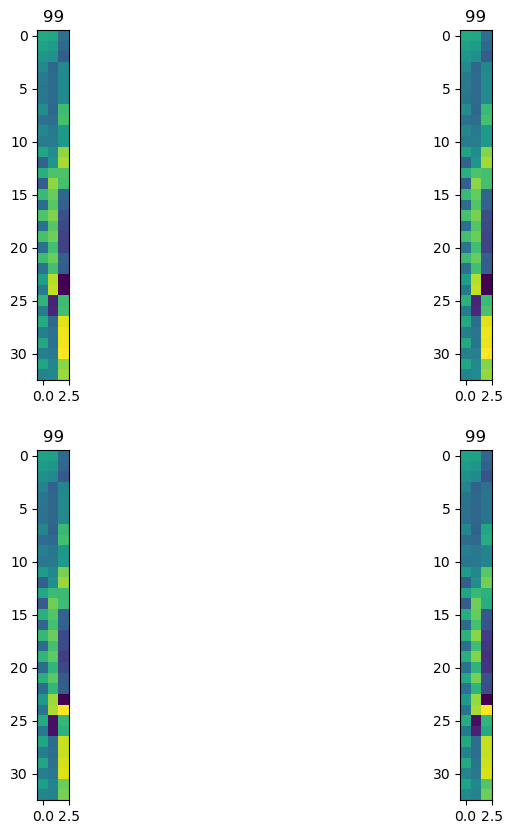

In [20]:
%matplotlib inline

## For image condition, not keypoints

plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::2]):
    plt.subplot(2,2,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

#### Define model parameters and Train model

In [21]:
class S3D_VisualHead(nn.Module):
    def __init__(self, S3D, VisualHeadV, VisualHeadK):
        super(S3D_VisualHead, self).__init__()
        self.hidden_size = 512
        self.S3D = S3D
        self.VisualHeadV = VisualHeadV
        self.VisualHeadK = VisualHeadK

        # Pyramid
        self.fc1 = nn.Linear(num_class, self.hidden_size)
        #self.bn1 = MaskedNorm(num_features=self.hidden_size, norm_type='sync_batch')
        self.relu1 = nn.ReLU()
        #self.conv = nn.Conv1d(2, 1, kernel_size=1, stride=1, padding=0, dilation=1, groups=1, bias=True)
        
        self.final_classifier = nn.Linear(self.hidden_size, num_class)
        self.softmax = nn.LogSoftmax(dim=1)  ## check dim
        #self.fc = nn.Linear(num_features, num_classes)
        
    def forward(self, x_v, x_k):
        s3d_outputs = self.S3D(x_v)
        vh_outputs_v = self.VisualHeadV(s3d_outputs['sgn'].cpu(), mask=s3d_outputs['sgn_mask'][-1].cpu(), 
                                        valid_len_in=s3d_outputs['valid_len_out'][-1].cpu())
                                        #valid_len_in=torch.ones([batch_size]))
                                        #valid_len_in=torch.ones(size=[batch_size], dtype=torch.int64))
        vh_outputs_k = self.VisualHeadK(x_k.cpu(), mask=None, 
                                        #valid_len_in=torch.tensor([1]).cpu())
                                        valid_len_in=s3d_outputs['valid_len_out'][-1].cpu())
                                        
        #print(vh_outputs_v['gloss_logits'].shape)
        #print(vh_outputs_k['gloss_logits'].shape)
        x = torch.cat((vh_outputs_v['gloss_probabilities'], vh_outputs_k['gloss_probabilities']), dim=1)  ## Check dim and pick what output
        x_v = vh_outputs_v['gloss_probabilities']
        x_k = vh_outputs_k['gloss_probabilities']
        
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.final_classifier(x)
        x = self.softmax(x)
        
        return x, x_v, x_k, vh_outputs_v["valid_len_out"], vh_outputs_k["valid_len_out"]

#file_weight = 'SLRTNGT/TwoStreamNetwork/pretrained_models/csl-daily_s2t/ckpts/best.ckpt'
#file_weight = 'SLRTNGT/TwoStreamNetwork/pretrained_models/s3ds_actioncls_ckpt/S3D_kinetics400.pt'
file_weight = 'SLRTNGT/TwoStreamNetwork/pretrained_models/s3ds_glosscls_ckpt/epoch299.pth.tar'

class_names = catgs

num_class = len(class_names)
print("Number of classes: " + str(num_class))

# Create S3D and load state_dicts    
#S3D = S3D(num_class, use_block=4, freeze_block=1)  ## 4 and 1 for gloss
S3D = S3D_backbone(num_class, in_channel=3, use_block=4, freeze_block=1, pretrained_ckpt=file_weight, cfg_pyramid=None)  ## 4 and 1 for gloss
S3D = S3D.cuda()
# load the weight file of S3D and copy the parameters
if os.path.isfile(file_weight):
    print ('loading weight file')
    weight_dict = torch.load(file_weight)
    model_dict = S3D.state_dict()
    for name, param in weight_dict.items(): # name is the name of the module, param is the weights
        if 'module' in name:
            name = '.'.join(name.split('.')[1:])
        if name in model_dict:
            if param.size() == model_dict[name].size():
                model_dict[name].copy_(param)
            else:
                print (' size? ' + name, param.size(), model_dict[name].size())
        else:
            print (' name? ' + name)
    print (' loaded')
else:
    print ('weight file?')
S3Dmodel = S3D.cuda()
torch.backends.cudnn.benchmark = False

## Create VisualHeads
VisualHeadV = VisualHead(num_class, pe=True).cpu()
VisualHeadK = VisualHead(num_class, input_size=33*3, pe=True).cpu()

model = S3D_VisualHead(S3Dmodel, VisualHeadV, VisualHeadK)

Number of classes: 146
loading weight file
 name? epoch
 name? state_dict
 name? best_acc
 name? optimizer
 loaded


##### Calculate Loss etc

In [52]:
import copy
import tqdm

def plot_loss(loss_hist, metric_hist):

    num_epochs= len(loss_hist["train"])

    plt.title("Train-|Val Loss")
    plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

def compute_recognition_loss(loss_func, gloss_labels, gloss_lengths, gloss_predictions, input_lengths):

    loss = loss_func(
        log_probs = gloss_predictions.permute(1,0,2), #T,N,C
        targets = gloss_labels,
        input_lengths = input_lengths,
        target_lengths = gloss_lengths
    )
    loss = loss/gloss_predictions.shape[0]
    return loss

def metrics_batch(output, target):
    batch_correct = 0
    for i, batch_item in enumerate(output):
        pred = batch_item.argmax(keepdim=False)
        corrects = 0
        for item in target:
            corrects += batch_item.eq(item).sum().item()
        batch_correct += corrects
    return batch_correct

def loss_batch(loss_func_ce, loss_func_ctc, output, valid_len_out, target, opt=None):

    #output_prob_ce = output['gloss_probabilities_log'].softmax(dim=1)
    #predictions = torch.argmax(output, dim=2)
    predictions = torch.transpose(output, 0, 1)

    CE_loss = 0  ##n check wat happens when remove
    for i, row in enumerate(predictions):
        ce_loss = loss_func_ce(row, target)
        CE_loss += ce_loss.item()
    
    #CE_loss = loss_func_ce(predictions, target)
    CTC_loss = compute_recognition_loss(loss_func_ctc, target, torch.tensor([1,1,1]), output, valid_len_out) #torch.tensor([1,1,1]))
    
    with torch.no_grad():
        metric_b = metrics_batch(predictions, target)
    if opt is not None:
        opt.zero_grad()
        ce_loss.backward(retain_graph=True)
        CTC_loss.backward()
        #loss.backward()
        opt.step()

    total_loss = (CE_loss*1 + CTC_loss.item()*3)/4 #+ CE_loss2.item()*1
    
    return total_loss, metric_b

def loss_epoch(model,loss_func_ce,loss_func_ctc,dataset_dl_v,dataset_dl_k,sanity_check=False,opt=None):
    running_loss_v=0.0
    running_metric_v=0.0
    running_wer_v=0.0
    running_loss_k=0.0
    running_metric_k=0.0
    running_wer_k=0.0
    len_data = len(dataset_dl_v.dataset)
    for (xb_v, yb_v), (xb_k, yb_k) in zip(dataset_dl_v, dataset_dl_k):
        xb_v = xb_v.cuda() #.to(device)
        x, x_v, x_k, valid_len_out_v, valid_len_out_k = model(xb_v, xb_k.cpu())
        
        #loss_b, metric_b = loss_batch(loss_func_ce, loss_func_ctc, x, valid_len_out, yb_v, opt)
        loss_b_v, metric_b_v = loss_batch(loss_func_ce, loss_func_ctc, x_v, valid_len_out_v, yb_v, opt) #doesn't matter if we pick yb_v or k, should be the same
        loss_b_k, metric_b_k = loss_batch(loss_func_ce, loss_func_ctc, x_k, valid_len_out_k, yb_k, opt)
        running_loss_v += loss_b_v
        running_loss_k += loss_b_k

        # GET ACCURACY
        if metric_b_v is not None:
            running_metric_v+=metric_b_v
        if metric_b_v is not None:
            running_metric_k+=metric_b_k
            
        if sanity_check is True:
            break

        # GET WORD ERROR RATE
        ####

    loss_v=running_loss_v/float(len_data)
    loss_k=running_loss_k/float(len_data)
    metric_v=running_metric_v/float(len_data)
    metric_k=running_metric_k/float(len_data)
    loss = loss_v + loss_k
    metric = metric_v + metric_k
    return loss, metric

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func_ctc=params["loss_func_ctc"]
    loss_func_ce=params["loss_func_ce"]
    opt=params["optimizer"]
    train_dl_v=params["train_dl_video"]
    train_dl_k=params["train_dl_keypoints"]
    val_dl_v=params["val_dl_video"]
    val_dl_k=params["val_dl_keypoints"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history={
        "train": [],
        "val": [],
    }

    metric_history={
        "train": [],
        "val": [],
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')

    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func_ce,loss_func_ctc,train_dl_v,train_dl_k,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func_ce,loss_func_ctc,val_dl_v,val_dl_k,sanity_check)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights")

        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights")
            model.load_state_dict(best_model_wts)


        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10)
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

##### Train model

In [53]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import tqdm

#model_type="S3DandVisualHeadTest"
model_type="VisualHeadKeypointTest"

loss_func_ctc = torch.nn.CTCLoss(zero_infinity=True, reduction='sum')
loss_func_ce = torch.nn.CrossEntropyLoss(reduction='sum', label_smoothing=0.1)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)        # original lr=3e-5 in baseline paper lr=1e-3. Baseline also uses adam with batch size of 8 and weight decay of 1e-3.
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.8, patience=3, verbose=True, groups=2??)    # patientce is 5, so after 5 epochs of no improvement learning rate is lr*factor, so halved
#lr_scheduler = CosineAnnealingLR(opt, T_max=40)     # maximum amount of iterations on the lr
os.makedirs("Thesis/Models", exist_ok=True)

params_train={
    "num_epochs": 80,
    "optimizer": opt,
    "loss_func_ctc": loss_func_ctc,
    "loss_func_ce": loss_func_ce,
    "train_dl_keypoints": train_dl_keypoints,
    "train_dl_video": train_dl_video,
    "val_dl_keypoints": test_dl_keypoints,
    "val_dl_video": test_dl_video,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": "Models/weights_"+model_type+".pt",
    }
model,loss_hist,metric_hist = train_val(model,params_train)

Epoch 0/79, current lr=0.001
Copied best model weights
train loss: 0.000657, dev loss: 0.005964, accuracy: 0.00
----------
Epoch 1/79, current lr=0.001
train loss: 0.000664, dev loss: 0.006134, accuracy: 0.00
----------
Epoch 2/79, current lr=0.001
train loss: 0.000684, dev loss: 0.006310, accuracy: 0.00
----------
Epoch 3/79, current lr=0.001
train loss: 0.000701, dev loss: 0.006137, accuracy: 0.00
----------
Epoch 4/79, current lr=0.001
Epoch 00005: reducing learning rate of group 0 to 8.0000e-04.
Loading best model weights
train loss: 0.000684, dev loss: 0.006032, accuracy: 0.00
----------
Epoch 5/79, current lr=0.0008
Copied best model weights
train loss: 0.000664, dev loss: 0.005947, accuracy: 0.00
----------
Epoch 6/79, current lr=0.0008
Copied best model weights
train loss: 0.000662, dev loss: 0.005942, accuracy: 0.00
----------
Epoch 7/79, current lr=0.0008
train loss: 0.000661, dev loss: 0.005944, accuracy: 0.00
----------
Epoch 8/79, current lr=0.0008
train loss: 0.000662, de

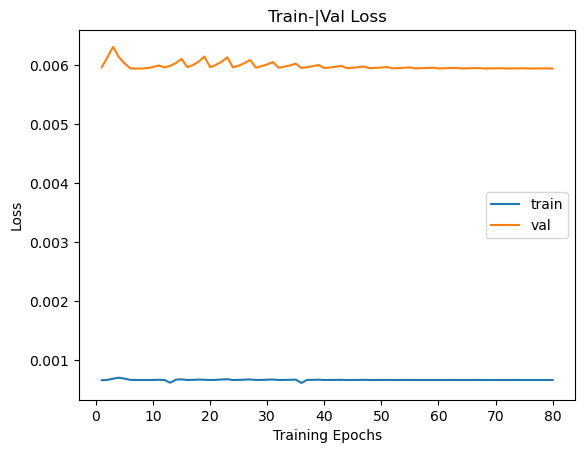

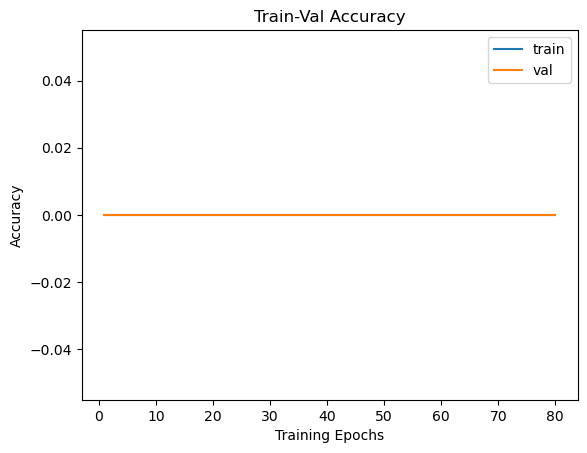

In [54]:
plot_loss(loss_hist, metric_hist)